<a href="https://colab.research.google.com/github/CarlosSMWolff/Parameter-Inference/blob/master/2-1-Training_1D_Delta_models-EXPLORATORY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of Neural Networks

>[Imports](#imports)

>[1D Models](#1D)

>>[Load data](#load)

>>[Model #1: RNN architecture](#RNN)

>>[Model #2: Hist-Dense architecture](#Hist)

# Imports
<a id='imports'></a>

In [1]:
# Find out if this notebook is running in Google Colab
import os
isColab= 'google.colab' in str(get_ipython())
if isColab:
  try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
  except KeyError:
    print('TPU not found')

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *
from scipy import stats
from scipy.linalg import expm
from scipy.stats import norm

from tqdm import tqdm

from numpy import exp
from cmath import sqrt

import glob
import pickle
if isColab:
  from google.colab import files
import gc

def plotfill(x,y,var, label, colorfill = "skyblue", colordata = "steelblue", alpha = 0.8, style = 'o'):
    plt.fill_between(x,y-var, y+var,color=colorfill,alpha=alpha,label=label)
    plt.plot(x,y,style,color=colordata,alpha=alpha)

print("Tensorflow has access to the following devices:")
for device in tf.config.list_physical_devices():
  print(f" {device}")

Tensorflow has access to the following devices:
 PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# 1D Models
<a id='1D'> </a>

## Load data
<a id='load'></a>

### Training data (1D $\Delta$ estimation)

- If this notebook is run online in Google Colab, we download the data from the online repo and the necessary src files.
- Otherwise, we accesss to the local data in `data/training`

In [2]:
if isColab:
  # Load src folder from Dropbox
  ! mkdir src
  ! wget -O src/custom_layers.py https://www.dropbox.com/scl/fi/nzv72gtdwel3pxdvwtan4/custom_layers.py?rlkey=3qvph73s2ltqfu796pzrju0wi&dl=0
  path_tau="taus-Delta-1D-4000000-trajs-24-09-2022.npy"
  path_param = "delta_rand_list-Delta-1D-4000000-trajs-24-09-2022.npy"
  if not os.path.isfile(path_tau):
    ! wget -q --show-progress https://www.dropbox.com/s/so6nlehcq8oexrz/taus-Delta-1D-4000000-trajs-24-09-2022.npy
  if not os.path.isfile(path_param):
    ! wget -q --show progress https://www.dropbox.com/s/3ruxgqsawgh3vcr/delta_rand_list-Delta-1D-4000000-trajs-24-09-2022.npy

else:
  path_tau="data/training/1D-Delta/taus-Delta-1D.npy"
  path_param="data/training/1D-Delta/delta_rand_list-Delta-1D.npy"

In [3]:
tau_list = np.load(path_tau)
Delta_list = np.load(path_param)

ntraj = len(tau_list)

if len(tau_list)!=len(Delta_list):
  print("ERROR: Dimensions of X (tau_list) and Y (Delta_list) do not match!")
else:
  print(f"{ntraj} trajectories loaded")

4000000 trajectories loaded


Select the number of trajectories that we want to use for the training

In [24]:
ntraj_select = 40000
tau_list = tau_list[:ntraj_select].astype(np.float32)
Delta_list = Delta_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [25]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, Delta_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

## Model #1: RNN architecture
<a id='RNN'></a>

Define and train the network

In [7]:
from src.custom_layers import ExpandDimLayer

def create_model():
  # Set the RNN
  dropout = 0.
  activation = "relu" 
  modelRNN = keras.models.Sequential(
  [ExpandDimLayer(),  # Add custom layer to expand dimensions
    keras.layers.LSTM(17,input_shape=[None,1],return_sequences=True, activation=activation,dropout=dropout),
  keras.layers.LSTM(17, return_sequences=False, activation=activation,dropout=dropout),
  keras.layers.Dense(1)]
  )
  return modelRNN

Training details

In [8]:
epochs = 200
batch_size = 12800
optimizer = "adam"
loss =  tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Perform training
- If the notebook is run in Colab, it tries to use TPU. 
- Otherwise, train in local machine.

In [9]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)



  with strategy.scope():
    modelRNN = create_model()
    modelRNN.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  historyRNN=modelRNN.fit(X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1
)

else:

  print("No colab! Local training")
  modelRNN = create_model()
  modelRNN.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  historyRNN=modelRNN.fit(X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1)


No colab! Local training
Epoch 1/200


2023-07-27 17:08:18.321435: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


12/25 [=============>................] - ETA: 4s - loss: 0.9047 - mean_squared_error: 16.7659

KeyboardInterrupt: 

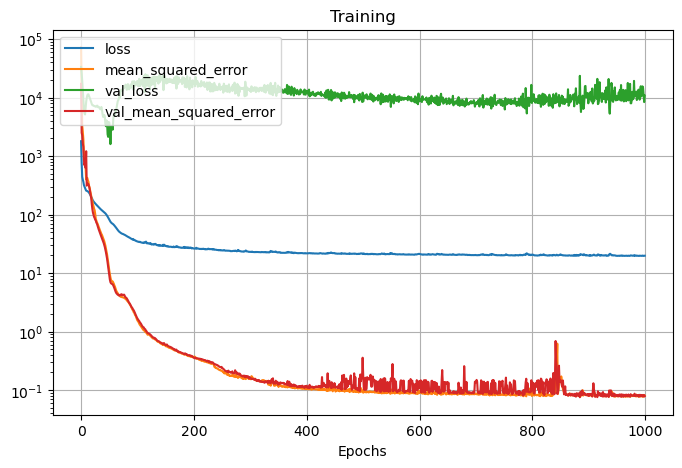

In [87]:
pd.DataFrame(historyRNN.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training")
plt.grid(True)
plt.yscale("log")
plt.show()

Visualize the predictions made by the model in the validation set

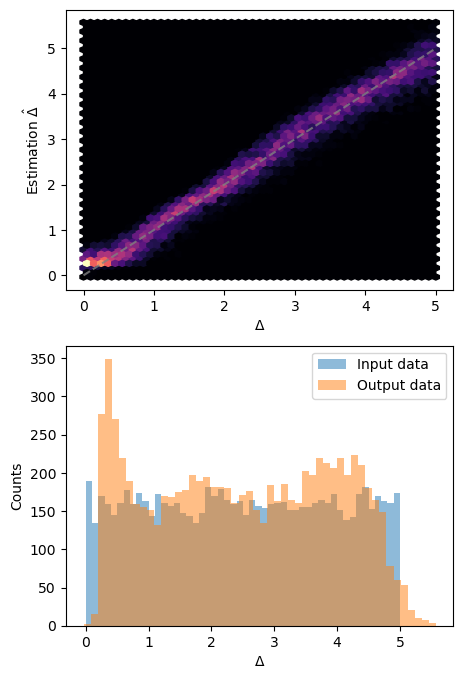

In [96]:
nsel = 10000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelRNN(x_values)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [97]:
modelTrainName = f'model-2LSTM-Dense-1D.h5'

if isColab:
    save_path = modelTrainName
else:
    save_path = "data/models/1D/"+modelTrainName

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(modelTrainName)

## Model #2: Hist-Dense architecture
<a id='Hist'></a>

Define the model


In [8]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 400
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Setup the training

In [64]:
  epochs = 50
  batch_size = 12800
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Training

In [65]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model_Hist()
    modelHist.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

  history=modelHist.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1)

else:
      modelHist = create_model_Hist()
      modelHist.compile(
        optimizer= optimizer,
        loss=loss,
              metrics=[metrics]
        )

      history=modelHist.fit(
      X_train, y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(X_valid, y_valid),
      validation_freq=1)


Epoch 1/50
3/3 [==============================] - 2s 466ms/step - loss: 1.2610 - mean_squared_error: 7.8596 - val_loss: 0.7900 - val_mean_squared_error: 6.0865
Epoch 2/50
3/3 [==============================] - 1s 409ms/step - loss: 0.6721 - mean_squared_error: 5.5164 - val_loss: 0.4352 - val_mean_squared_error: 4.1678
Epoch 3/50
3/3 [==============================] - 1s 408ms/step - loss: 0.3817 - mean_squared_error: 3.7330 - val_loss: 0.2901 - val_mean_squared_error: 2.8274
Epoch 4/50
3/3 [==============================] - 1s 409ms/step - loss: 0.2645 - mean_squared_error: 2.5283 - val_loss: 0.2251 - val_mean_squared_error: 1.9379
Epoch 5/50
3/3 [==============================] - 1s 410ms/step - loss: 0.2057 - mean_squared_error: 1.7134 - val_loss: 0.1726 - val_mean_squared_error: 1.2831
Epoch 6/50
3/3 [==============================] - 1s 414ms/step - loss: 0.1533 - mean_squared_error: 1.1117 - val_loss: 0.1149 - val_mean_squared_error: 0.7713
Epoch 7/50
3/3 [========================

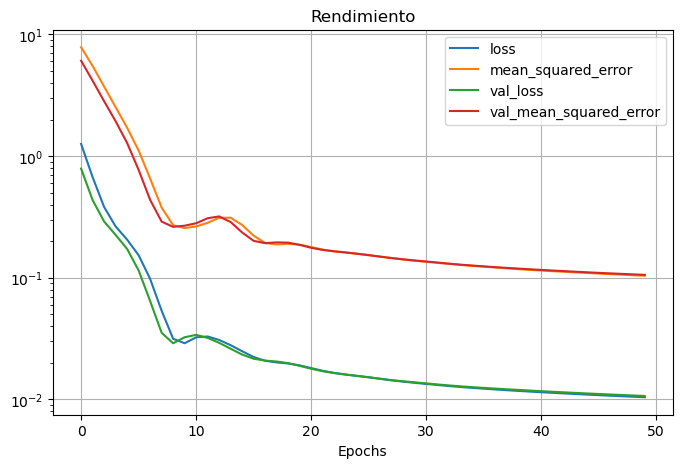

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Rendimiento")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

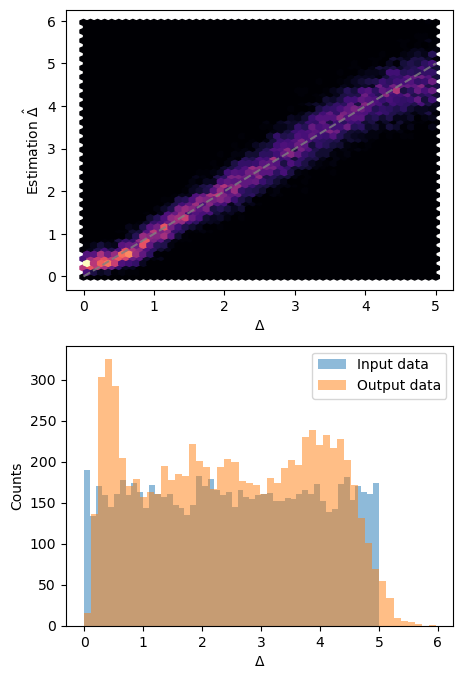

In [68]:
nsel = 10000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelHist.predict(x_values, verbose=False)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [ ]:
modelTrainName = f'model-Hist-Dense-1D.h5'

if isColab:
    save_path = modelTrainName
else:
    save_path = "data/models/1D/"+modelTrainName

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(modelTrainName)

In [ ]:
'''custom_objects = {"CustomLayer": MyHistogramLayer_Sigmoid, "histogram_sigmoid": histogram_sigmoid}

with keras.saving.custom_object_scope(custom_objects):
    reconstructed_model = keras.models.load_model(modelTrainName, compile=False)'''

### Training with noise

#### Training Hist-Dense models with noise in the y_train

Define the model

In [ ]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 400
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Define $\sigma$ interval

In [109]:
#sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(sigma_min,sigma_max,nsigma)

sigma_min = 0.;sigma_max = 1.;nsigma = 10; sigma_list = np.linspace(sigma_min,sigma_max,nsigma)

Setup the training

In [110]:
  epochs = 3
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Create callback to save the model of the best epoch during training

In [111]:
def Create_Callback(sigma):
  filepath='data/models/1D/noise-y-train/model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [112]:
if isColab:
  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model_Hist()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  sigma = 0.
  noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
  y_train_noise = np.abs(y_train + noise)
  noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
  y_valid_noise = np.abs(y_valid + noise_valid)

  model_Prev.fit(X_train.astype(np.float32),
                        y_train_noise.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for sigma in tqdm(sigma_list):

      # First we create a model cloning the partially trained one
      with strategy.scope():
        model = tf.keras.models.clone_model(model_Prev)
        model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

        # Add noise to data
        noise = np.random.normal(loc=0., scale=sigma, size=len(y_train_Hist))
        y_train_noise = np.abs(y_train_Hist + noise)
        noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
        y_valid_noise = np.abs(y_valid + noise_valid)

        # Fit the model with noisy data
        history = model.fit(X_train.astype(np.float32),
                        y_train_noise.astype(np.float32),
                        epochs=20,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                         verbose = False)

        # Store the history of the training
        history_list.append(history)

else:
  print("No Colab found: Training locally.")
  modelHist = create_model_Hist()
  modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  model_Prev = tf.keras.models.clone_model(modelHist)
  model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  sigma = 0.
  noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
  y_train_noise = np.abs(y_train + noise)
  noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
  y_valid_noise = np.abs(y_valid + noise_valid)

  model_Prev.fit(X_train.astype(np.float32),
                        y_train_noise.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(sigma),
                         batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for sigma in tqdm(sigma_list):

      # First we create a model cloning the partially trained one
 
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

      # Add noise to data
      noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
      y_train_noise = np.abs(y_train + noise)
      noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
      y_valid_noise = np.abs(y_valid + noise_valid)

      # Fit the model with noisy data
      history = model.fit(X_train.astype(np.float32),
                      y_train_noise.astype(np.float32),
                      epochs=20,
                      callbacks=Create_Callback(sigma),
                        batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                        verbose = False)

        # Store the history of the training
      history_list.append(history)

No Colab found: Training locally.


100%|██████████| 10/10 [03:53<00:00, 23.39s/it]


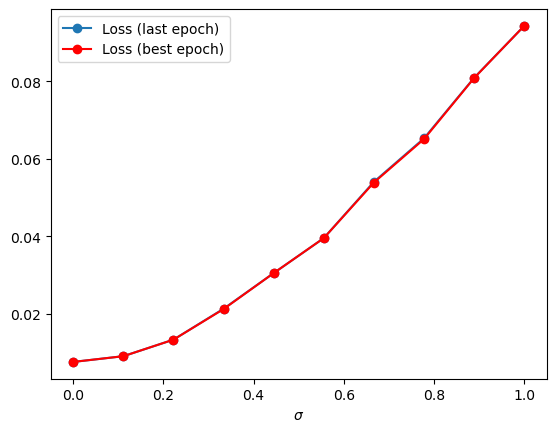

In [119]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

plt.plot(sigma_list,val_loss_list[:,-1],'-o', label = "Loss (last epoch)")
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro', label = "Loss (best epoch)")
plt.legend()
plt.xlabel("$\sigma$"); plt.ylabel("")
plt.show()

### Training Hist models with noise in the x_train

Define the model

In [26]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 400
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Define $\sigma$ interval

In [27]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

Setup the training

In [28]:
epochs = 100
batch_size = 1280
#optimizer = tf.keras.optimizers.legacy.Adam(  learning_rate=0.0001)
optimizer = "adam"
loss = tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Define Callback to save the model of the best epoch during training

In [29]:
def Create_Callback(sigma):
  filepath='data/models/noise-x-train/model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [38]:
if isColab:
  print("We are in Google Colab! Trying to train with TPU.")

  tf.keras.backend.clear_session()

  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

  strategy = tf.distribute.TPUStrategy(resolver)

  with strategy.scope():
    modelHist = create_model_Hist()
    modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  with strategy.scope():
    model_Prev = tf.keras.models.clone_model(modelHist)
    model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # First do a very quick training to initialize the weights for later training
  model_Prev.fit(X_train.astype(np.float32),
                        y_train.astype(np.float32),
                        epochs=2,
                        callbacks=Create_Callback(sigma),
                         batch_size = batch_size, validation_data=(X_valid.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                         verbose = False)

  # Now loop over sigma
  history_list = []
  for sigma in tqdm(sigma_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    # Add noise to x- data (delays)
    noise = np.random.normal(loc=0., scale=sigma, size=tau_list.shape)
    tau_list_noise = (tau_list + noise).clip(min=0.001)
    #Proper shape to x-data
    X_train_full_Hist = tau_list_noise
    lenTrain=int(0.8*len(X_train_full))
    X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]

    # Fit the model with noisy data
    history = model.fit(X_train_Hist.astype(np.float32),
                    y_train.astype(np.float32),
                    epochs=epochs,
                    callbacks=Create_Callback(sigma),
                      batch_size = batch_size, validation_data=(X_valid_Hist.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                      verbose = False)

      # Store the history of the training
    history_list.append(history)

else:
  print("No Colab detected. Training locally.")
  
  history_list = []
  for sigma in tqdm(sigma_list):

    # First we create a model cloning the partially trained one

    model = create_model_Hist()
    model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

    # Add noise to x- data (delays)
    noise = np.random.normal(loc=0., scale=sigma, size=tau_list.shape)
    tau_list_noise = (tau_list + noise).clip(min=0.001)
    #Proper shape to x-data
    X_train_full_Hist = tau_list_noise
    lenTrain=int(0.8*len(X_train_full))
    X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]

    # Fit the model with noisy data
    history = model.fit(X_train_Hist.astype(np.float32),
                    y_train.astype(np.float32),
                    epochs=epochs,
                    callbacks=Create_Callback(sigma),
                      batch_size = batch_size, validation_data=(X_valid_Hist.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                      verbose = False)

      # Store the history of the training
    history_list.append(history)

No Colab detected. Training locally.


100%|██████████| 10/10 [01:54<00:00, 11.48s/it]


# 2D Models